<a href="https://colab.research.google.com/github/lorenafc/Capita_Selecta_RHI50403/blob/main/Maps_authors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install libraries
!pip install cartopy -q
!pip install contextily -q
!pip install pyproj -q
!pip install matplotlib-scalebar -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.1 MB/s eta 0:00:00


In [2]:
#import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import os
import imageio
import random
import numpy as np
import re

from pyproj import Geod
from moviepy.editor import ImageSequenceClip
from shapely.geometry import Point, LineString
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches


In [4]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#upload the file
from google.colab import files
uploaded=files.upload()

Saving additional_authors_complete_geocoded_GoogleAPI_drive.xlsx to additional_authors_complete_geocoded_GoogleAPI_drive.xlsx


In [6]:
file_name = 'additional_authors_complete_geocoded_GoogleAPI_drive.xlsx'
authors_small_cities = pd.read_excel(file_name, engine='openpyxl')
authors_small_cities_copy=authors_small_cities.copy()


In [ ]:
authors_small_cities.head()

indexauthor                        starturl birthyear  deathyear  \
0            0   http://viaf.org/viaf/81048146      1570     1634.0   
1            1  http://viaf.org/viaf/180581759       NaN     1775.0   
2            2  http://viaf.org/viaf/100161519       NaN     1570.0   
3            3  http://viaf.org/viaf/169350346      1699     1770.0   
4            4   http://viaf.org/viaf/67541728      1502     1600.0   

                         nameandbirthdeathyear  \
0             Carneiro, Tomé Tavares 1570-1634   
1                     Kolíček, Caesarij, -1775   
2                     Hertel, Jakob 15..?-1570   
3  Ferro Caaveyro, Lucas Antonio ca. 1699-1770   
4       Aparicio, Sebastián de 1502-1600 Santo   

                                     georeferenceurl  borncity    deathcity  \
0                                  viafprocessedfile                    NaN   
1                                  viafprocessedfile                Cieszin   
2     http://catalogue.bnf.fr/ark:/12148/cb15011774s     (Chur          NaN   
3  www.wikidata.org/wiki/Q3393623#sitelinks-wikip...  A Capela          NaN   
4  www.wikidata.org/wiki/Q2486114#sitelinks-wikip...  A Gudiña  Puebla City   

  activecity  latitude_born  longitude_born  latitude_death  longitude_death  \
0  Rio Tinto            NaN             NaN             NaN              NaN   
1        NaN            NaN             NaN       49.749764        18.635471   
2        NaN      46.850783        9.531986             NaN              NaN   
3        NaN            NaN             NaN             NaN              NaN   
4        NaN      42.060574       -7.139303       19.041440       -98.206273   

   latitude_active  longitude_active  
0              NaN               NaN  
1              NaN               NaN  
2              NaN               NaN  
3              NaN               NaN  
4              NaN               NaN

In [7]:
authors_small_cities = authors_small_cities.rename(columns={'bitrhyear': 'birthyear'})

In [8]:
# Create GeoSeries for birth, death, and active points
birth_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                              for xy in zip(authors_small_cities['longitude_born'], authors_small_cities['latitude_born'])], crs="EPSG:4326")
death_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                              for xy in zip(authors_small_cities['longitude_death'], authors_small_cities['latitude_death'])], crs="EPSG:4326")
active_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                               for xy in zip(authors_small_cities['longitude_active'], authors_small_cities['latitude_active'])], crs="EPSG:4326")

# Combine birth, death, and active points into a single GeoSeries, prioritizing death points first, then active points, and finally birth points
combined_points = death_points.fillna(active_points).fillna(birth_points)

# Now create a GeoDataFrame using the combined geometry column
authors_small_cities_combined = gpd.GeoDataFrame(authors_small_cities, geometry=combined_points)
authors_small_cities_combined = authors_small_cities_combined[authors_small_cities_combined.geometry.notnull()]

# Adjust the years: prioritize death year, if missing, use birth year + 60
# Convert 'birthyear' to numeric, coerce errors to NaN
authors_small_cities_combined['birthyear'] = pd.to_numeric(authors_small_cities_combined['birthyear'], errors='coerce')
authors_small_cities_combined['effective_year'] = authors_small_cities_combined['deathyear'].fillna(authors_small_cities_combined['birthyear'] + 60)

# Set the CRS for the new GeoDataFrame
authors_small_cities_combined = authors_small_cities_combined.set_crs("EPSG:4326").to_crs(epsg=3857)

# Filter the DataFrame from 800 to 1800
authors_small_cities_combined = authors_small_cities_combined[
    (authors_small_cities_combined['effective_year'] >= 800) & (authors_small_cities_combined['effective_year'] <= 1800)
].copy()

# Active Maps - Gif

- Authors in the map from 10 years before their death

- used death place when active was not available

## WORLD

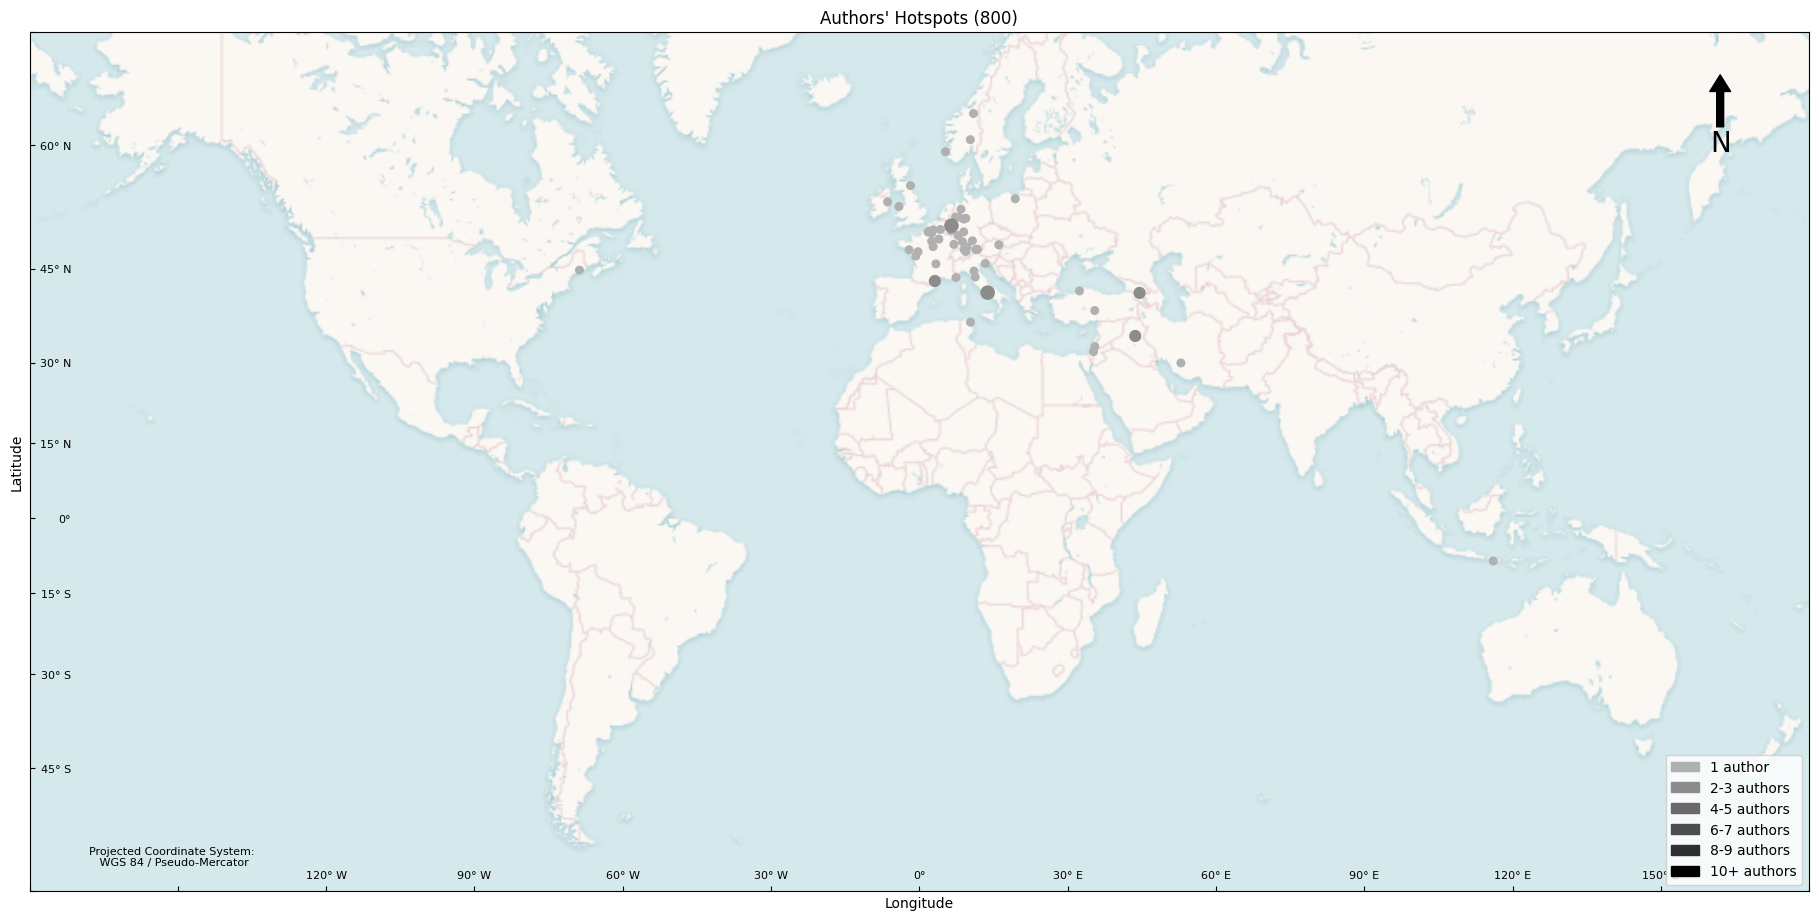

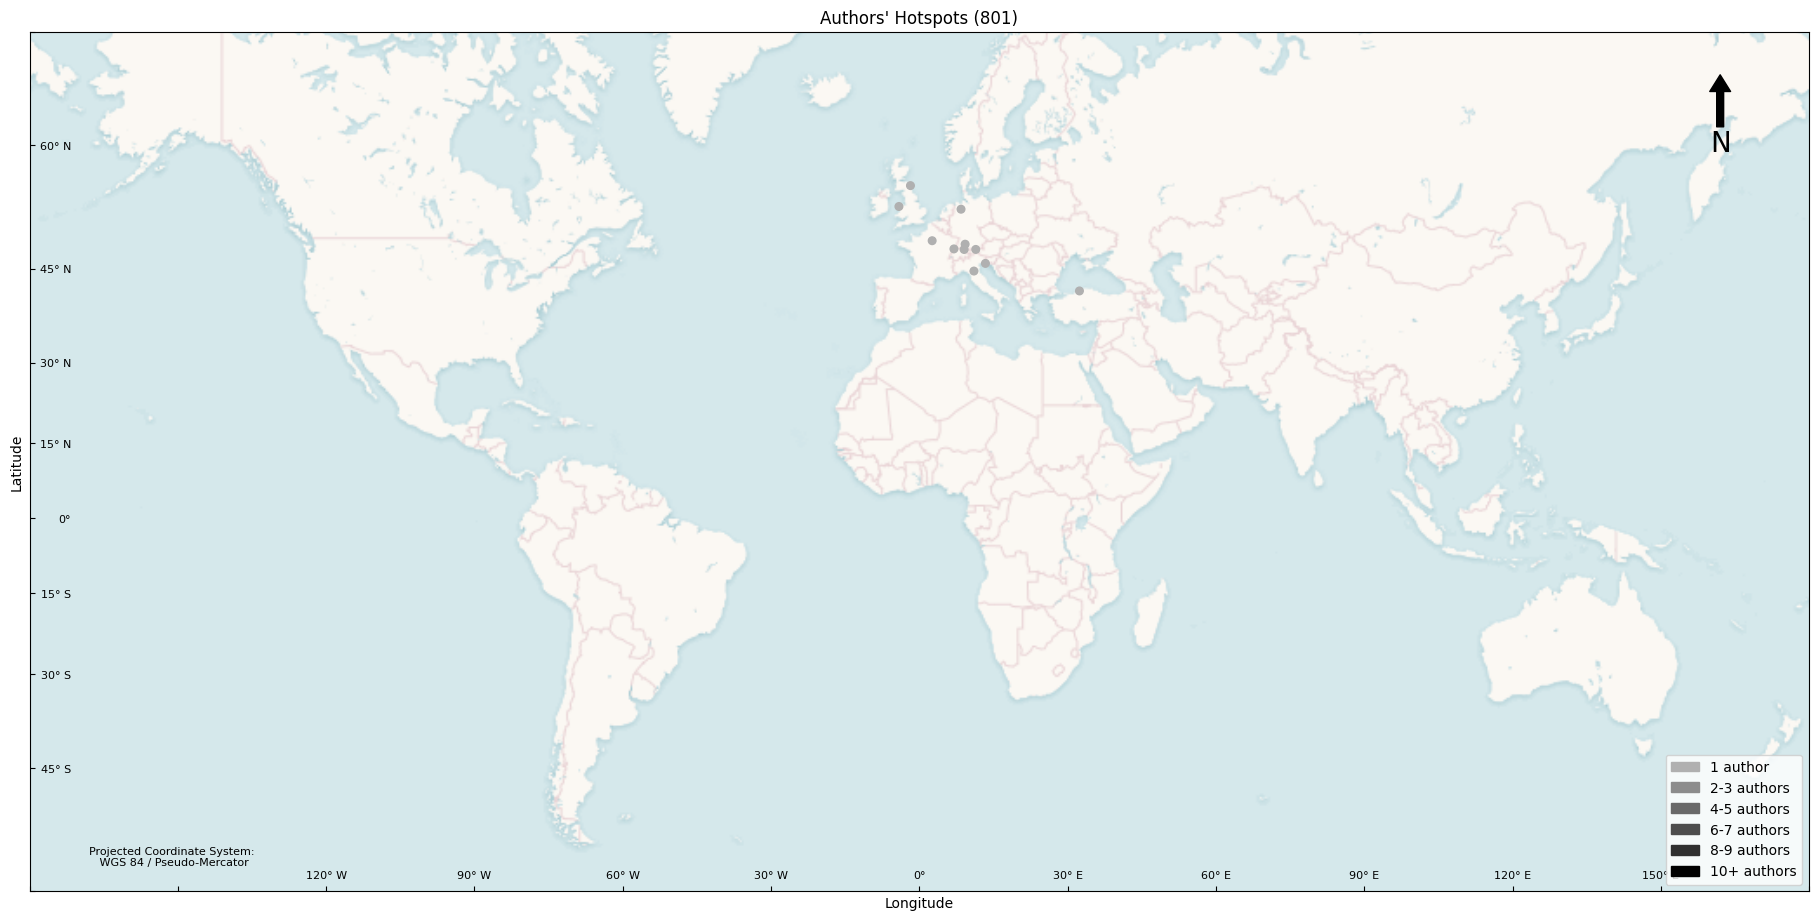

In [60]:
# source: Lucas Koren and chatgpt

# Define the start and end years

startyear = 800
endyear = 801
step = 1
batch_size = 100  # Number of years to process in each batch

output_images_dir = "/content/drive/My Drive/capita_selecta/gif_world_googleapi/"
os.makedirs(output_images_dir, exist_ok=True)

# Define the function
def plot_maps_per_year(startyear, endyear, step, batch_size, authors_small_cities_combined, output_images_dir):


    """
    Generates a series of maps showing authors' activity hotspots for each year within the specified range and saves the maps as PNG files.

    Parameters:
    startyear (int): The starting year for generating maps.
    endyear (int): The ending year for generating maps.
    step (int): The step size between years to be processed.
    batch_size (int): The number of years to process in each batch.
    authors_small_cities_combined (GeoDataFrame): GeoDataFrame containing author data with columns for death year and geometry.
    output_images_dir (str): The directory where the output plot images will be saved.

    """
    # World boundaries in Web Mercator projection
    world_bounds = [-20037508.34, -8399737.88, 20037508.34, 10958014.95]

    # Invisible points to ensure full basemap is displayed
    invisible_points = gpd.GeoDataFrame({
        'geometry': [
            Point(-20037508.34, -20037508.34),  # Bottom left
            Point(20037508.34, -20037508.34),   # Bottom right
            Point(-20037508.34, 20037508.34),   # Top left
            Point(20037508.34, 20037508.34)     # Top right
        ],
        'point_count': [0, 0, 0, 0]
    }, crs="EPSG:3857")

    # Define a custom color map
    cmap = mcolors.ListedColormap(['#B0B0B0', '#8C8C8C', '#696969', '#4D4D4D', '#303030', '#000000'])
    bounds = [1, 2, 4, 6, 8, 10]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Function to determine opacity
    def get_opacity(count):
        if count >= 10:
            return 0.4  # 40% opacity
        elif count >= 4:
            return 0.6  # 60% opacity
        else:
            return 1.0  # No transparency

    # Loop through the timesteps in batches
    for batch_start in range(startyear, endyear, batch_size):
        batch_end = min(batch_start + batch_size, endyear)

        # Loop through the timesteps in the current batch
        for i, timestep in enumerate(range(batch_start - 1, batch_end, step)):
            # Create a string to represent the current timestep
            years = f"{timestep + 1}"

            # Filter the GeoDataFrame for authors active in the timestep for 10 years prior to his/her death
            authors_active_timestep = authors_small_cities_combined[
                (authors_small_cities_combined['effective_year'] > timestep) &
                (authors_small_cities_combined['effective_year'] <= timestep + 10)
            ]

            # Check if there are any valid records for the current timestep
            if not authors_active_timestep.empty:
                # Group by unique points and get the count for each group and turn into geodataframe
                unique_points_gdf = gpd.GeoDataFrame(
                    authors_active_timestep.groupby('geometry').size().reset_index(name='point_count'),
                    geometry='geometry'
                )

                # Ensure the CRS is set to EPSG:3857 for latitude and longitude
                unique_points_gdf = unique_points_gdf.set_crs(epsg=3857, allow_override=True)

                # Add invisible points to ensure full basemap is displayed
                unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

                # Add opacity column based on the point_count
                unique_points_gdf['opacity'] = unique_points_gdf['point_count'].apply(get_opacity)

                fig, ax = plt.subplots(figsize=(19, 10))

                # Plot the points with the custom color map and varying transparency
                unique_points_gdf.plot(
                    ax=ax,
                    column='point_count',
                    cmap=cmap,
                    norm=norm,
                    markersize=unique_points_gdf['point_count'] * 30,
                    aspect=0.7,
                    alpha=unique_points_gdf['opacity']  # Use the opacity column here
                )

                # Add basemap with fixed zoom level
                cx.add_basemap(ax, attribution=False, zoom=2, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

                # tight layout
                fig.tight_layout(pad=3)

                # labels inside the map
                ax.tick_params(direction="in")

                # Set plot limits to fixed geographic bounds
                ax.set_xlim(world_bounds[0], world_bounds[2])
                ax.set_ylim(world_bounds[1], world_bounds[3])

                # Set title and axis labels
                ax.set_title(f"Authors' Hotspots ({years})")
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')

                # Set tick labels to show the Mercator projection coordinates
                ax.set_xticks([-20037508.34, -16697923.611, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16697923.61, 20037508.34])
                ax.set_xticklabels(['', '', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', ''])

                ax.set_yticks([-8399737.88, -5621521.48, -3503549.84, -1689200.13, 0, 1689200.13, 3503549.84, 5621521.48, 8399737.88, 10958014.95])
                ax.set_yticklabels(["", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", ""])

                # Disable the grid lines
                ax.grid(False)

                # Adjust position of tick labels
                ax.tick_params(axis='x', pad=-15, labelsize=8)
                ax.tick_params(axis='y', pad=-30, labelsize=8)

                # Add the Projected coordinate System
                ax.annotate("Projected Coordinate System:\n WGS 84 / Pseudo-Mercator", xy=(0.08,0.04), ha= "center", va="center", fontsize=8, xycoords= ax.transAxes)

                # Create a legend
                legend_handles = [
                    mpatches.Patch(color="#B0B0B0", label="1 author"),     # Lightest Grey
                    mpatches.Patch(color="#8C8C8C", label="2-3 authors"),  # Light Grey
                    mpatches.Patch(color="#696969", label="4-5 authors"),  # Medium Grey
                    mpatches.Patch(color="#4D4D4D", label="6-7 authors"),  # Dark Grey
                    mpatches.Patch(color="#303030", label="8-9 authors"),  # Very Dark Grey
                    mpatches.Patch(color="#000000", label="10+ authors")   # Black
                ]

                # Add the legend to the plot
                ax.legend(handles=legend_handles, loc='lower right')

                # North arrow
                x, y, arrow_length = 0.95, 0.95, 0.08
                ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                            arrowprops=dict(facecolor='black', width=5, headwidth=15),
                            ha='center', va='center', fontsize=20,
                            xycoords=ax.transAxes)

                # Save plot as .png file
                output_path = os.path.join(output_images_dir, f"active_hotspot_world_year_{years}.png")
                plt.savefig(output_path)
                plt.close(fig)  # Close the figure to avoid memory issues
                # plt.show()





plot_maps_per_year(startyear, endyear, step, batch_size, authors_small_cities_combined, output_images_dir)


### Create Gif and Video

In [ ]:
### Create the gifs and video
#source: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python and chat gpt


# Function to extract numerical values from filenames
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group(0)) if match else -1

# Path to the directory containing the images
image_dir = "/content/drive/My Drive/capita_selecta/gif_world_googleapi/" #update your path

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"The directory {image_dir} does not exist.")
else:
    print(f"Directory {image_dir} exists. Proceeding with file processing.")

    # List all the image files in the directory
    image_files = sorted(
        [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')],
        key=lambda x: extract_number(os.path.basename(x))
    )

    # Ensure the list is not empty
    if not image_files:
        print("No images found in the specified directory.")
    else:
        # Create a GIF (the gif works with 500 images but not with all of them on colab. I used VS code to make the gif with all the images from 800 to 1800)
        # gif_output_path = os.path.join(image_dir, 'authors_active_world.gif')
        # images = [imageio.imread(file) for file in image_files]
        # imageio.mimsave(gif_output_path, images, fps=25, loop=0)  # Adjust fps as needed
        # print(f"GIF saved at {gif_output_path}")

        # Create a video
        video_output_path = os.path.join(image_dir, 'authors_active_world_googleapi.mp4')
        clip = ImageSequenceClip(image_files, fps=25)  # Adjust fps as needed
        clip.write_videofile(video_output_path, codec='libx264')
        print(f"Video saved at {video_output_path}")


Directory /content/drive/My Drive/capita_selecta/gif_world_googleapi/ exists. Proceeding with file processing.
No images found in the specified directory.


## EUROPE 10 years

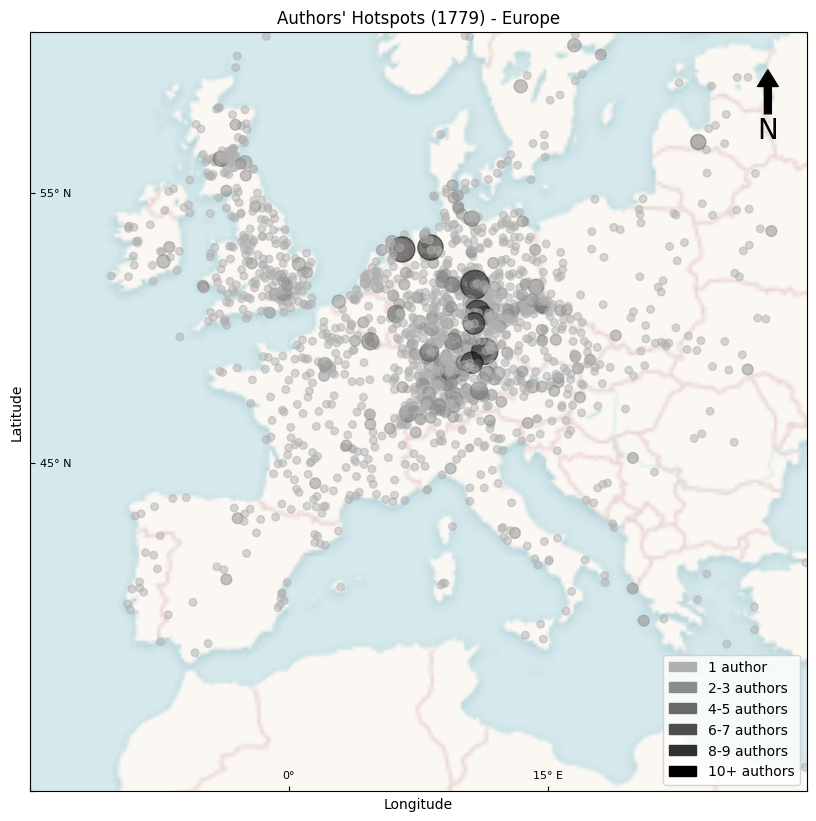

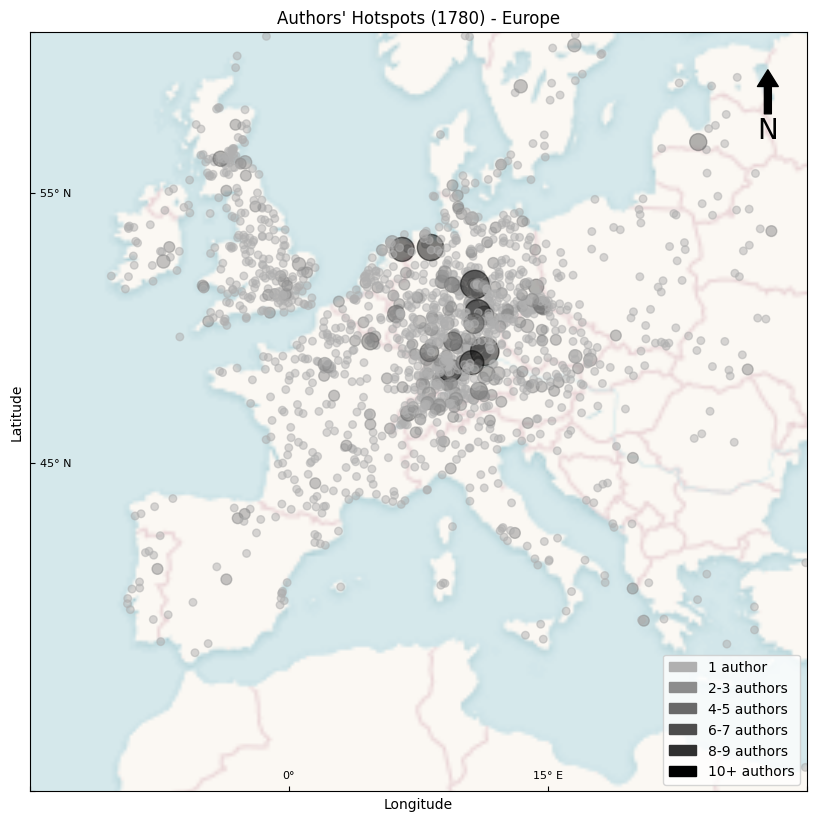

In [53]:
#### EUROPE (using invisible points)

# source: Lucas Koren and chatgpt

startyear = 1779
endyear = 1780
step = 1
batch_size = 100  # Number of years to process in each batch
output_images_dir = "/content/drive/My Drive/capita_selecta/gif_europe_googleapi/"

# Define the function
def plot_maps_per_year_europe(startyear, endyear, step, batch_size, authors_small_cities_combined, output_images_dir):

    """
    Generates a series of maps showing authors' activity hotspots for each year within the specified range in Europe and saves the maps as PNG files.

    Parameters:
    startyear (int): The starting year for generating maps.
    endyear (int): The ending year for generating maps.
    step (int): The step size between years to be processed.
    batch_size (int): The number of years to process in each batch.
    authors_small_cities_combined (GeoDataFrame): GeoDataFrame containing author data with columns for death year and geometry.
    output_images_dir (str): The directory where the output plot images will be saved.

    """

    os.makedirs(output_images_dir, exist_ok=True)

    # Europe boundaries in Web Mercator projection:
    world_bounds = [-1669792, 3503549.84, 3339584.72, 8399737.88]

    # Invisible points to ensure full basemap is displayed
    invisible_points = gpd.GeoDataFrame({
        'geometry': [
            Point(-20037508.34, -20037508.34),  # Bottom left
            Point(20037508.34, -20037508.34),   # Bottom right
            Point(-20037508.34, 20037508.34),   # Top left
            Point(20037508.34, 20037508.34)     # Top right
        ],
        'point_count': [0, 0, 0, 0]
    }, crs="EPSG:3857")

    # Define a custom color map
    cmap = mcolors.ListedColormap(['#B0B0B0', '#8C8C8C', '#696969', '#4D4D4D', '#303030', '#000000'])
    bounds = [1, 2, 4, 6, 8, 10]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Loop through the timesteps in batches
    for batch_start in range(startyear, endyear, batch_size):
        batch_end = min(batch_start + batch_size, endyear)

        # Loop through the timesteps in the current batch
        for i, timestep in enumerate(range(batch_start - 1, batch_end, step)):
            # Create a string to represent the current timestep
            years = f"{timestep + 1}"

            # Filter the GeoDataFrame for authors active in the timestep for 10 years prior to his/her death
            authors_active_timestep = authors_small_cities_combined[
                (authors_small_cities_combined['deathyear'] > timestep) &
                (authors_small_cities_combined['deathyear'] <= timestep + 10)
            ]

            # Check if there are any valid records for the current timestep
            if not authors_active_timestep.empty:
                # Group by unique points and get the count for each group and turn into geodataframe
                unique_points_gdf = gpd.GeoDataFrame(
                    authors_active_timestep.groupby('geometry').size().reset_index(name='point_count'),
                    geometry='geometry'
                )

                # Ensure the CRS is set to EPSG:3857 for latitude and longitude
                unique_points_gdf = unique_points_gdf.set_crs(epsg=3857, allow_override=True)

                # Add invisible points to ensure full basemap is displayed
                unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

                fig, ax = plt.subplots(figsize=(10, 9))

                # Plot the points with the custom color map
                unique_points_gdf.plot(ax=ax, column='point_count', cmap=cmap, norm=norm, markersize=unique_points_gdf["point_count"]*30, aspect=0.7, alpha=0.5)

                # Add basemap with fixed zoom level
                cx.add_basemap(ax, attribution=False, zoom=3, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

                # tight layout
                fig.tight_layout(pad=3)

                # labels inside the map
                ax.tick_params(direction="in")

                # Set plot limits to fixed geographic bounds
                ax.set_xlim(world_bounds[0], world_bounds[2])
                ax.set_ylim(world_bounds[1], world_bounds[3])

                # Set title and axis labels
                ax.set_title(f"Authors' Hotspots ({years}) - Europe")
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')

                ax.set_xticks([-1669792, 0, 1669792, 3339584.72])
                ax.set_xticklabels(['', '0°', '15° E', ''])

                ax.set_yticks([3503549.84, 5621521, 7361866, 8399737.88])
                ax.set_yticklabels(['', '45° N', '55° N', ''])

                # Disable the grid lines
                ax.grid(False)

                # Adjust position of tick labels
                ax.tick_params(axis='x', pad=-15, labelsize=8)
                ax.tick_params(axis='y', pad=-30, labelsize=8)

                # Create a legend
                legend_handles = [
                    mpatches.Patch(color="#B0B0B0", label="1 author"),     # Lightest Grey
                    mpatches.Patch(color="#8C8C8C", label="2-3 authors"),  # Light Grey
                    mpatches.Patch(color="#696969", label="4-5 authors"),  # Medium Grey
                    mpatches.Patch(color="#4D4D4D", label="6-7 authors"),  # Dark Grey
                    mpatches.Patch(color="#303030", label="8-9 authors"),  # Very Dark Grey
                    mpatches.Patch(color="#000000", label="10+ authors")   # Black
                ]

                # Add the legend to the plot
                ax.legend(handles=legend_handles, loc='lower right')

                # North arrow
                x, y, arrow_length = 0.95, 0.95, 0.08
                ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                            arrowprops=dict(facecolor='black', width=5, headwidth=15),
                            ha='center', va='center', fontsize=20,
                            xycoords=ax.transAxes)

                # Save plot as .png file
                # output_path = os.path.join(output_images_dir, f"active_hotspot_europe_year_{years}_googleapi.png")
                # plt.savefig(output_path)
                # plt.close(fig)  # Close the figure to avoid memory issues
                plt.show()




plot_maps_per_year_europe(startyear, endyear, step, batch_size, authors_small_cities_combined, output_images_dir)


## Gif and Video - Europe

In [ ]:
### Create the gifs and video
#source: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python and chat gpt

# Function to extract numerical values from filenames
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group(0)) if match else -1

# Path to the directory containing the images
image_dir = "/content/drive/My Drive/capita_selecta/gif_europe_googleapi/" #update your path

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"The directory {image_dir} does not exist.")
else:
    print(f"Directory {image_dir} exists. Proceeding with file processing.")

    # List all the image files in the directory
    image_files = sorted(
        [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')],
        key=lambda x: extract_number(os.path.basename(x))
    )

    # Ensure the list is not empty
    if not image_files:
        print("No images found in the specified directory.")
    else:
        # Create a GIF (the gif works with 500 images but not with all of them on colab. I used VS code to make the gif with all the images from 800 to 1800)
        # gif_output_path = os.path.join(image_dir, 'authors_active_europe.gif')
        # images = [imageio.imread(file) for file in image_files]
        # imageio.mimsave(gif_output_path, images, fps=30, loop=0)  # Adjust fps as needed
        # print(f"GIF saved at {gif_output_path}")

        # Create a video
        video_output_path = os.path.join(image_dir, 'authors_active_europe_googleapi.mp4')
        clip = ImageSequenceClip(image_files, fps=30)  # Adjust fps as needed
        clip.write_videofile(video_output_path, codec='libx264')
        print(f"Video saved at {video_output_path}")


Directory /content/drive/My Drive/capita_selecta/gif_europe_googleapi/ exists. Proceeding with file processing.
Moviepy - Building video /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4.
Moviepy - Writing video /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4
Video saved at /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4


# Birth Death Map - 800-1800

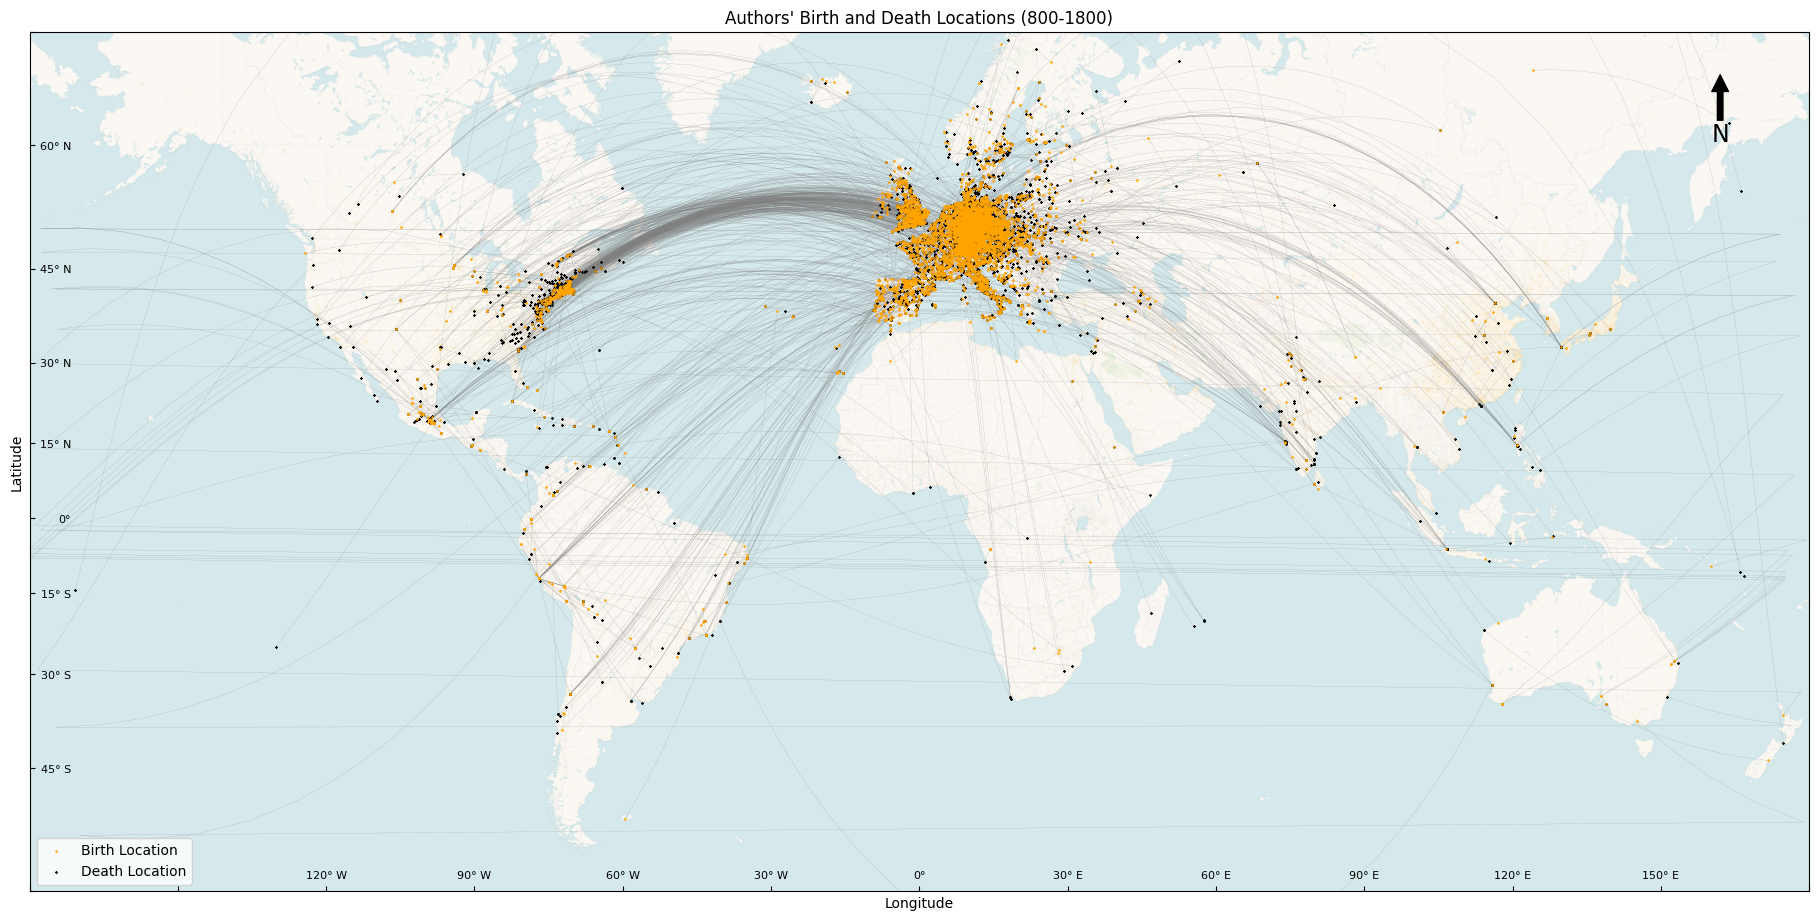

In [52]:
# source: Lucas Koren and chatgpt

start_year = 800
end_year = 1800
output_dir = "/content/drive/My Drive/capita_selecta/active_maps/"

def plot_authors_birth_death(authors_df, start_year, end_year, output_dir):

    """
    Plots the birth and death locations of authors along with geodesic lines connecting these points on a map.

    Parameters:
    authors_df (DataFrame): DataFrame containing author data with columns for latitude and longitude of birth and death.
    start_year (int): The start year for filtering the authors.
    end_year (int): The end year for filtering the authors.
    output_dir (str): The directory where the output plot image will be saved.

    """
    # Filter years between start_year and end_year
    authors_df = authors_df[(authors_df['deathyear'] >= start_year) & (authors_df['deathyear'] <= end_year)]

    # Drop rows where the birth or death latitude/longitude is NaN
    authors_df = authors_df.dropna(subset=['latitude_born', 'longitude_born', 'latitude_death', 'longitude_death'])

    # Create Points for birth and death locations
    authors_df['birth_point'] = authors_df.apply(lambda row: Point(row['longitude_born'], row['latitude_born']), axis=1)
    authors_df['death_point'] = authors_df.apply(lambda row: Point(row['longitude_death'], row['latitude_death']), axis=1)

    # Create geodesic lines between birth and death points
    def create_geodesic_line(row):
        geod = Geod(ellps="WGS84")
        lon1, lat1 = row['longitude_born'], row['latitude_born']
        lon2, lat2 = row['longitude_death'], row['latitude_death']
        # Use npts method to calculate geodesic line
        points = geod.npts(lon1, lat1, lon2, lat2, 20) # Use npts to get intermediate points
        # Create a LineString from the calculated points
        return LineString([(lon1, lat1)] + points + [(lon2, lat2)])

    authors_df['line'] = authors_df.apply(create_geodesic_line, axis=1)

    # Create GeoDataFrames for points and lines
    birth_points_gdf = gpd.GeoDataFrame(authors_df, geometry='birth_point')
    death_points_gdf = gpd.GeoDataFrame(authors_df, geometry='death_point')
    lines_gdf = gpd.GeoDataFrame(authors_df, geometry='line')

    # Ensure the GeoDataFrame uses the WGS84 coordinate reference system
    birth_points_gdf.set_crs(epsg=4326, inplace=True)
    death_points_gdf.set_crs(epsg=4326, inplace=True)
    lines_gdf.set_crs(epsg=4326, inplace=True)

    # Convert to Web Mercator projection for plotting with basemap
    birth_points_gdf = birth_points_gdf.to_crs(epsg=3857)
    death_points_gdf = death_points_gdf.to_crs(epsg=3857)
    lines_gdf = lines_gdf.to_crs(epsg=3857)

    world_bounds = [-20037508.34, -8399737.88, 20037508.34, 10958014.95] # World boundaries

    fig, ax = plt.subplots(figsize=(19, 10))

    # Plot the birth points in orange
    birth_points_gdf.plot(ax=ax, color='orange', alpha=0.8, markersize=1, marker="*", zorder=3, label='Birth Locations')

    # Plot the death points in black
    death_points_gdf.plot(ax=ax, color='black', markersize=1, marker="x", zorder=2, label='Death Locations')

    # Plot the lines
    lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

    # Add basemap with fixed zoom level
    cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
    fig.tight_layout(pad=3)
    ax.tick_params(direction="in")

    # Disable the grid lines
    ax.grid(False)

    # Add legend
    plt.legend(['Birth Location', 'Death Location'], loc="lower left")

    # North arrow
    x, y, arrow_length = 0.95, 0.95, 0.07
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=4, headwidth=12),
                ha='center', va='center', fontsize=17,
                xycoords=ax.transAxes)

    # Set plot limits to fixed geographic bounds
    ax.set_xlim(world_bounds[0], world_bounds[2])
    ax.set_ylim(world_bounds[1], world_bounds[3])

    # Set title and axis labels
    ax.set_title("Authors' Birth and Death Locations (800-1800)")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set tick labels to show the Mercator projection coordinates
    ax.set_xticks([-20037508.34, -16697923.611, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16697923.61, 20037508.34])
    ax.set_xticklabels(['', '', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', ''])

    ax.set_yticks([-8399737.88, -5621521.48, -3503549.84, -1689200.13, 0, 1689200.13, 3503549.84, 5621521.48, 8399737.88, 10958014.95])
    ax.set_yticklabels(["", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", ""])

    # Disable the grid lines
    ax.grid(False)

    # Adjust position of tick labels
    ax.tick_params(axis='x', pad=-15, labelsize=8)
    ax.tick_params(axis='y', pad=-30, labelsize=8)

    # Save plot as .png file
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/authors_birth_death_world_{start_year}-{end_year}.png")

    # Close the current figure to avoid overlapping plots
    plt.show()



plot_authors_birth_death(authors_small_cities_copy, start_year, end_year, output_dir)


## EUROPE

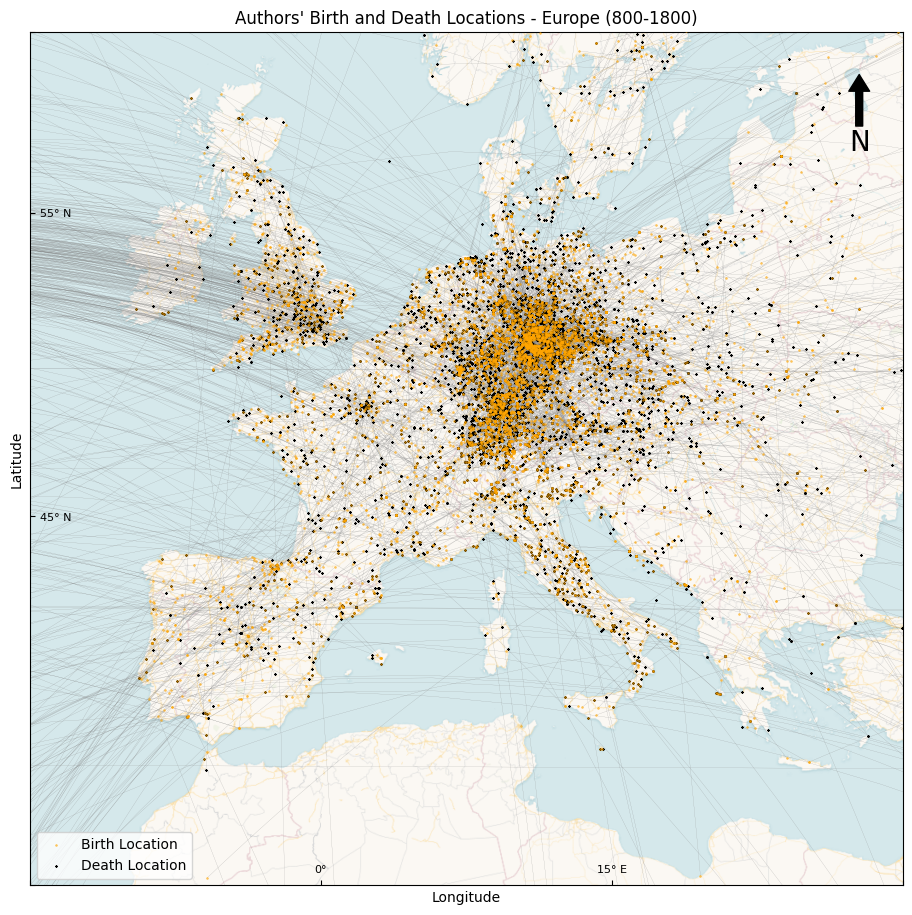

In [55]:
# EUROPE

#source: Lucas Koren and chatGPT

def plot_authors_birth_death_europe(birth_points_gdf, death_points_gdf, lines_gdf, output_dir):
    """
    Plots a map showing authors' birth and death locations in Europe between 800 and 1800 and saves the map as a PNG file.

    Parameters:
    birth_points_gdf (GeoDataFrame): GeoDataFrame containing authors' birth locations with columns for latitude, longitude, and geometry.
    death_points_gdf (GeoDataFrame): GeoDataFrame containing authors' death locations with columns for latitude, longitude, and geometry.
    lines_gdf (GeoDataFrame): GeoDataFrame containing geodesic lines representing the path from birth to death locations.
    output_dir (str): Directory where the output PNG file will be saved.

    """

    # Europe boundaries in Web Mercator projection
    bounds = [-1669792, 3503549.84, 3339584.72, 8399737.88]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the birth points in orange
    birth_points_gdf.plot(ax=ax, color='orange', alpha=0.5, markersize=1, marker="*", zorder=3, label='Birth Locations')

    # Plot the death points in black
    death_points_gdf.plot(ax=ax, color='black', alpha=1, markersize=1, marker="x", zorder=2, label='Death Locations')

    # Plot the lines connecting birth and death locations
    lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

    # Add a basemap with a fixed zoom level
    cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

    fig.tight_layout(pad=3)
    ax.tick_params(direction="in")

    # Add legend
    plt.legend(['Birth Location', 'Death Location'], loc="lower left")

    # Add a north arrow
    x, y, arrow_length = 0.95, 0.95, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes)

    # Set plot limits to fixed geographic bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    # Set title and axis labels
    ax.set_title("Authors' Birth and Death Locations - Europe (800-1800)")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set tick labels to show the Mercator projection coordinates
    ax.set_xticks([-1669792, 0, 1669792, 3339584.72])
    ax.set_xticklabels(['', '0°', '15° E', ''])

    ax.set_yticks([3503549.84, 5621521, 7361866, 8399737.88])
    ax.set_yticklabels(['', '45° N', '55° N', ''])

    # Adjust position of tick labels
    ax.tick_params(axis='x', pad=-15, labelsize=8)
    ax.tick_params(axis='y', pad=-30, labelsize=8)

    # Save plot as .png file
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/authors_birth_death_europe_curved_800-1800.png")

    # Close the current figure to avoid overlapping plots
    plt.show()

plot_authors_birth_death_europe(birth_points_gdf, death_points_gdf, lines_gdf, output_dir)

## CENTRAL EUROPE

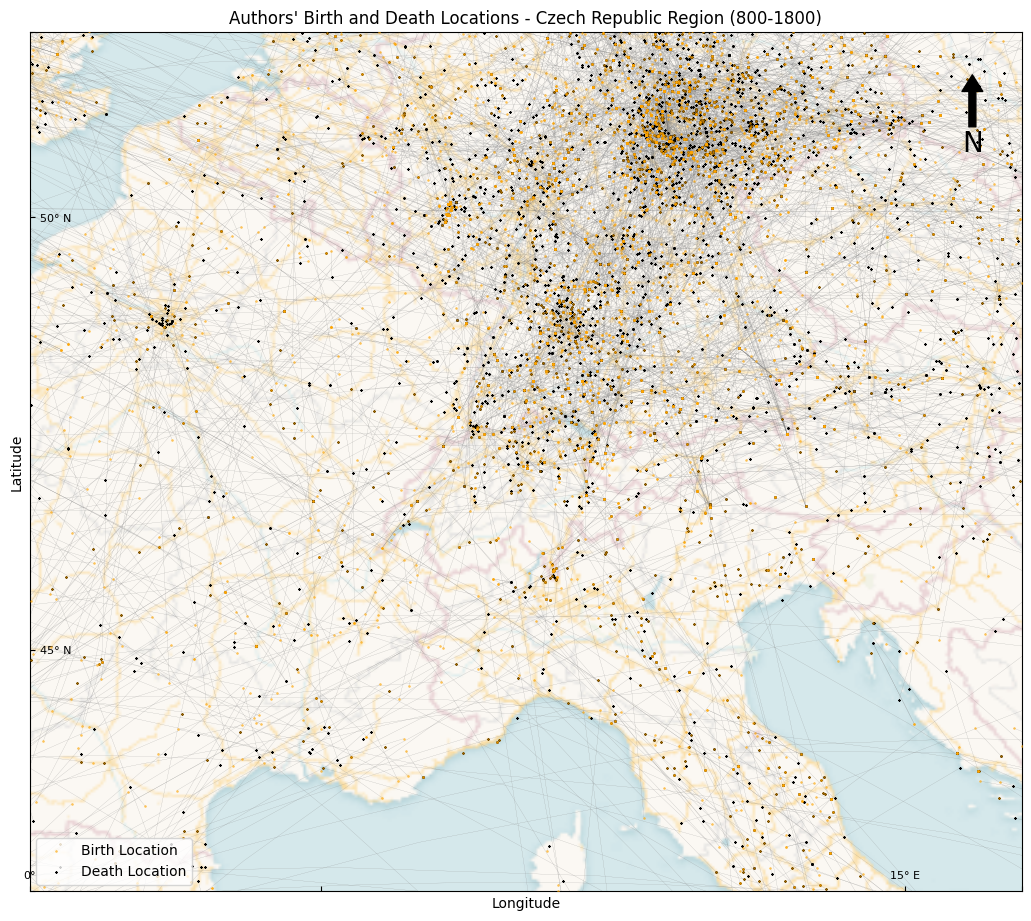

In [56]:
####  Europe - Germany and surroundings

#source: Lucas Koren and chatGPT

def plot_central_europe_authors(birth_points_gdf, death_points_gdf, lines_gdf, output_dir):
    """
    Plots a map of authors' birth and death locations in the Europe region, focused on Germany, including connecting lines.
    Saves the map as a PNG file.

    Parameters:
    birth_points_gdf (GeoDataFrame): GeoDataFrame containing authors' birth locations with columns for latitude, longitude, and geometry.
    death_points_gdf (GeoDataFrame): GeoDataFrame containing authors' death locations with columns for latitude, longitude, and geometry.
    lines_gdf (GeoDataFrame): GeoDataFrame containing lines representing connections between birth and death locations.
    output_dir (str): Directory where the output PNG file will be saved.


    """

    # Europe boundaries, zoomed in Germany, in Web Mercator projection
    bounds = [556597.4, 5160979.44,1892431.34, 6800125.45]

    fig, ax = plt.subplots(figsize=(19, 10))

    # Plot the birth points in orange
    birth_points_gdf.plot(ax=ax, color='orange', alpha=0.5, markersize=1, marker="*", zorder=3, label='Birth Locations')

    # Plot the death points in black
    death_points_gdf.plot(ax=ax, color='black', alpha=1, markersize=1, marker="x", zorder=2, label='Death Locations')

    # Plot the lines connecting birth and death locations
    lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

    # Add a basemap with a fixed zoom level
    cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

    fig.tight_layout(pad=3)
    ax.tick_params(direction="in")

    # Add legend
    plt.legend(['Birth Location', 'Death Location'], loc="lower left")

    # Add a north arrow
    x, y, arrow_length = 0.95, 0.95, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes)

    # Set plot limits to fixed geographic bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    # Set title and axis labels
    ax.set_title("Authors' Birth and Death Locations - Czech Republic Region (800-1800)")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set tick labels to show the Mercator projection coordinates relevant to the Czech Republic region
    ax.set_xticks([556597.4, 0, 1669792, 1892431.34])
    ax.set_xticklabels(['', '0°', '15° E', ''])

    ax.set_yticks([5160979.44, 5621521, 6446275, 6800125.45])
    ax.set_yticklabels(['', '45° N', '50° N', ''])

    # Adjust position of tick labels
    ax.tick_params(axis='x', pad=-15, labelsize=8)
    ax.tick_params(axis='y', pad=-30, labelsize=8)

    # Save plot as .png file
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/authors_birth_death_europe_germany_curved_800-1800.png")

    # plot the figure
    plt.show()

plot_central_europe_authors(birth_points_gdf, death_points_gdf, lines_gdf, output_dir)

## EAST COAST USA

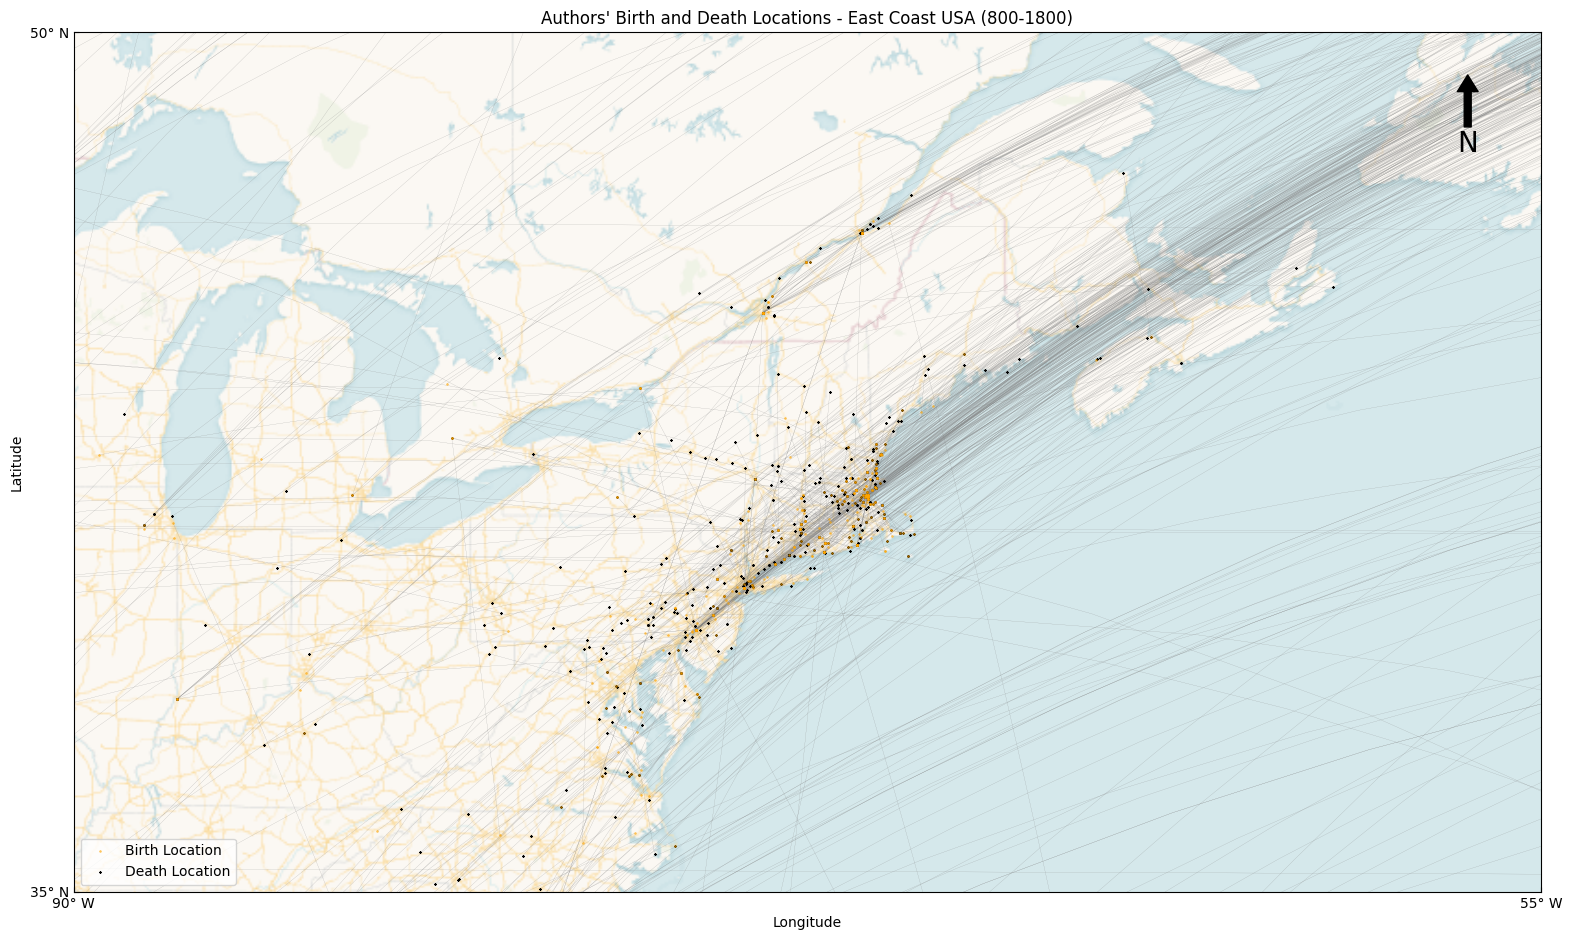

In [58]:
#EAST COAST USA

#source: Lucas Koren and chatGPT

def plot_east_coast_usa_authors(birth_points_gdf, death_points_gdf, lines_gdf, output_dir):
    """
    Plots a map of authors' birth and death locations along the East Coast of the USA, including connecting lines.
    Saves the map as a PNG file.

    Parameters:
    birth_points_gdf (GeoDataFrame): GeoDataFrame containing authors' birth locations with columns for latitude, longitude, and geometry.
    death_points_gdf (GeoDataFrame): GeoDataFrame containing authors' death locations with columns for latitude, longitude, and geometry.
    lines_gdf (GeoDataFrame): GeoDataFrame containing lines representing connections between birth and death locations.
    output_dir (str): Directory where the output PNG file will be saved.

    """

    # Boundaries for the East Coast USA region (approximation)
    bounds = [-10018754.17, 4163881.14, -6122571.99, 6446275.84]

    fig, ax = plt.subplots(figsize=(19, 10))

    # Plot the birth points in orange
    birth_points_gdf.plot(ax=ax, color='orange', alpha=0.5, markersize=1, marker="*", zorder=3, label='Birth Locations')

    # Plot the death points in black
    death_points_gdf.plot(ax=ax, color='black', alpha=1, markersize=1, marker="x", zorder=2, label='Death Locations')

    # Plot the lines connecting birth and death locations
    lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

    # Add a basemap with a fixed zoom level
    cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

    fig.tight_layout(pad=3)
    ax.tick_params(direction="in")

    # Add legend
    plt.legend(['Birth Location', 'Death Location'], loc="lower left")

    # Add a north arrow
    x, y, arrow_length = 0.95, 0.95, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes)

    # Set plot limits to fixed geographic bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    # Set title and axis labels
    ax.set_title("Authors' Birth and Death Locations - East Coast USA (800-1800)")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set tick labels to show the Mercator projection coordinates relevant to the East Coast USA
    ax.set_xticks([ -10018754.17, -6122571.99])
    ax.set_xticklabels(['90° W', '55° W'])

    ax.set_yticks([ 4163881.14, 6446275.84])
    ax.set_yticklabels(['35° N', "50° N"])

    # Save plot as .png file
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/authors_birth_death_east_coast_usa_800-1800.png")

    # Display the plot
    plt.show()

plot_east_coast_usa_authors(birth_points_gdf, death_points_gdf, lines_gdf, output_dir)